---
description: Use camera intrinsics to undistort video and gaze data
---

# Use Camera Intrinsics to Undistort Video and Gaze Data
Pupil Invisible's scene camera has a very large field of view and is affected by lens distortion accordingly. Every scene camera is calibrated during manufacturing though, which allows us to remove the distortion if desired.

In this guide you will learn how to download the camera intrinsic values of your scene camera, which are required for undistortion and how to use them in OpenCV to apply undistortion to the scene video and gaze data.

<div class="pb-4">
  <img width="100%" height="auto" src="../../../../media/invisible/how-tos/cloud_gaze_overlay_undistorted.jpeg" alt="An example of undistortion">
</div>

### Python Dependencies for this How-To

In order to run the code in this How-To, you will need to install the following Python dependencies:

```
pip install av matplotlib numpy opencv-python pandas requests tqdm
```

### Obtaining Camera Intrinsic Values
You can easily download the camera intrinsic values of all your Pupil Invisible scene cameras via the Pupil Cloud API. All you need is the serial number of your scene camera, which you can find on the back of the scene camera module or in the `info.json` file in one of your recordings. Note, that the serial of the scene camera is different from the serial number of the Pupil Invisible frame, which you can find at the tip of the left temple.

Once you have the serial, you can download the intrinsics after inserting it in the following URL:
```
https://api.cloud.pupil-labs.com/v2/hardware/<serial-number>/calibration.v1?json
```

The following code will download the intrinsics from the URL and extract its two components, the camera matrix and the distortion coefficients.

In [1]:
import requests
import numpy as np

serial_number_scene_cam = "thb4f"

url = f"https://api.cloud.pupil-labs.com/v2/hardware/{serial_number_scene_cam}/calibration.v1?json"
resp = requests.get(url)
resp.raise_for_status()
intrinsics = resp.json()["result"]
camera_matrix = np.array(intrinsics["camera_matrix"])
dist_coefs = np.array(intrinsics["dist_coefs"])

print("Camera Matrix: \n", camera_matrix)
print("Distortion Coefficients: \n", dist_coefs)


Camera Matrix: 
 [[757.13903916   0.         538.44291996]
 [  0.         756.62656123 549.13829392]
 [  0.           0.           1.        ]]
Distortion Coefficients: 
 [[-1.25621199e-01  1.00506169e-01 -1.29727060e-03  1.01058580e-05
   1.85375926e-02  2.03238323e-01  7.60370191e-03  6.60443289e-02]]


### Undistorting Images and Points
With the camera matrix and distortion coefficients available, we are now able to undistort images and points. If we want to undistort the scene camera video, it is critical that we undistort the gaze data as well. The gaze data is in scene camera coordinates and if we warp the scene camera images via undistortion, the gaze would otherwise no longer be accurate.

For simplicity, we will first undistort only a single image and a few artificial example points. Afterwards, we will go through an example of undistorting and entire Pupil Invisible recording.

The original distorted data looks as follows. Note that some lines that are straight in real life appear slightly curved in the image due to the distortion. For example the rail of the lamp, or the edges of the paintings.

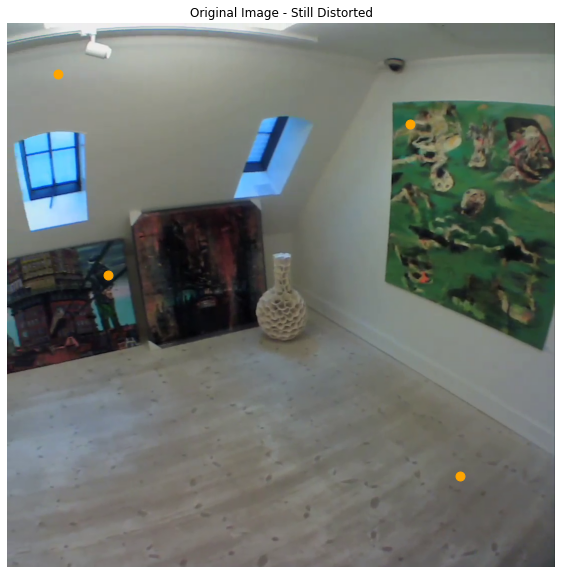

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("data/example_frame.png")
# Convert color space for plotting with matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


example_points = np.array(
    [
        (100.0, 100.0),
        (800.0, 200.0),
        (200.0, 500.0),
        (900.0, 900.0),
    ]
)

# Plot the original distorted version
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.scatter(example_points[:, 0], example_points[:, 1], color="orange", s=80)
plt.title("Original Image - Still Distorted")
plt.axis("off");


We can now use the OpenCV methods `undistort` and `undistortPoints` to undistort the image and example points. Note how all straight lines appear straight in the undistorted image. Also, the image is slightly cropped, e.g. the rail of the lamp is no longer in the image and the top left example point is outside the image now.

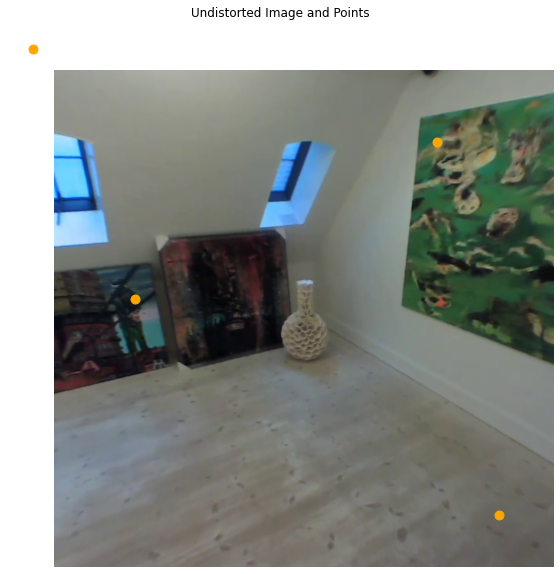

In [3]:
img_undist = cv2.undistort(img, camera_matrix, dist_coefs)

example_points_undist = cv2.undistortPoints(
    example_points.reshape(-1, 2), camera_matrix, dist_coefs, P=camera_matrix
)
example_points_undist = example_points_undist.reshape(-1, 2)

# Plot the undistorted version
plt.figure(figsize=(10, 10))
plt.imshow(img_undist)
plt.scatter(
    example_points_undist[:, 0], example_points_undist[:, 1], color="orange", s=80
)
plt.title("Undistorted Image and Points")
plt.axis("off");


### Undistort a full Recording
To undistort a full recording we simply need to apply the undistortion to every video frame and all gaze data. This requires a good bit of additional code to handle the video correctly, but works just the same.

You can download the recording used in this example [here](https://drive.google.com/file/d/1CGVgP6GWbEESoJUMB2YiD_gNN4JicK75/view?usp=sharing).
Edit the `recording_folder` variable below such that it points to the downloaded and
extracted recording.

Note, that we are using PyAV to handle the video rather than OpenCV. This is because OpenCV can run into issues with skipping frames and PyAV additionally allows us to correctly handle the audio track of the video, if there is one.

In [4]:
import pathlib

import av
from tqdm import tqdm
import pandas as pd


def undistort_video(
    original_video_path, undistorted_video_path, camera_matrix, dist_coefs
):
    timestamps_path = pathlib.Path(original_video_path).with_name(
        "world_timestamps.csv"
    )
    num_frames = pd.read_csv(timestamps_path).shape[0]
    original_container = av.open(str(original_video_path))
    original_video_stream = original_container.streams.video[0]

    undistorted_container = av.open(str(undistorted_video_path), "w")

    try:
        undistorted_video = undistorted_container.add_stream("h264_nvenc")
    except Exception as e:
        print("nvenc not available", e)
        undistorted_video = undistorted_container.add_stream("h264")

    undistorted_video.options["bf"] = "0"
    undistorted_video.options["movflags"] = "faststart"
    undistorted_video.gop_size = original_video_stream.gop_size
    undistorted_video.codec_context.height = original_video_stream.height
    undistorted_video.codec_context.width = original_video_stream.width
    undistorted_video.codec_context.time_base = original_video_stream.time_base
    undistorted_video.codec_context.bit_rate = original_video_stream.bit_rate

    if original_container.streams.audio:
        audio_stream = original_container.streams.audio[0]
        output_audio_stream = undistorted_container.add_stream("aac")
        output_audio_stream.codec_context.layout = audio_stream.layout.name
        output_audio_stream.codec_context.time_base = audio_stream.time_base
        output_audio_stream.codec_context.bit_rate = audio_stream.bit_rate
        output_audio_stream.codec_context.sample_rate = audio_stream.sample_rate

    progress = tqdm(unit=" frames", total=num_frames)
    with undistorted_container:
        for packet in original_container.demux():
            frames = packet.decode()

            if packet.stream.type == "audio":
                for frame in frames:
                    packets = output_audio_stream.encode(frame)
                    undistorted_container.mux(packets)
            elif packet.stream.type == "video":
                for frame in frames:
                    img = frame.to_ndarray(format="bgr24")
                    undistorted_img = cv2.undistort(img, camera_matrix, dist_coefs)
                    new_frame = frame.from_ndarray(undistorted_img, format="bgr24")
                    new_frame.pts = frame.pts
                    new_frame.time_base = original_video_stream.time_base
                    packets = undistorted_video.encode(new_frame)
                    progress.update()
                    undistorted_container.mux(packets)
        # encode and mux frames that have been queued internally by the encoders
        undistorted_container.mux(output_audio_stream.encode())
        undistorted_container.mux(undistorted_video.encode())


def undistort_gaze(original_gaze_path, unditorted_gaze_path):
    original_gaze_df = pd.read_csv(original_gaze_path)
    original_gaze = original_gaze_df[["gaze x [px]", "gaze y [px]"]].values
    undistorted_gaze = cv2.undistortPoints(
        original_gaze.reshape(-1, 2), camera_matrix, dist_coefs, P=camera_matrix
    )

    undistorted_gaze_df = original_gaze_df.copy()
    undistorted_gaze_df[["gaze x [px]", "gaze y [px]"]] = undistorted_gaze.reshape(-1, 2)
    undistorted_gaze_df.to_csv(unditorted_gaze_path, index=False)


In [5]:
recording_folder = "data/upstairs_1_(viewing)-07da3ea4/"

original_video_path = recording_folder + "2abada29_0.0-70.531.mp4"
undistorted_video_path = recording_folder + "2abada29_0.0-70.531_undistorted.mp4"
undistort_video(original_video_path, undistorted_video_path, camera_matrix, dist_coefs)

original_gaze_path = recording_folder + "gaze.csv"
undistorted_gaze_path = recording_folder + "gaze_undist.csv"
undistort_gaze(original_gaze_path, undistorted_gaze_path)


nvenc not available h264_nvenc


100%|██████████| 2086/2086 [01:41<00:00, 20.58 frames/s]
